In [1]:
import nibabel as nb

%matplotlib inline
import cv2
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from operator import itemgetter
init_notebook_mode(connected=True) 

In [2]:
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage.util import montage
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
CT_OFFSET = 1024
ZERO_VALUE = -2000
min_z = 10000

In [3]:
def read_dicom_array_2(in_path, volume_name):
    # type: (str) -> Tuple[int, np.ndarray]
    lung_dicom = pydicom.read_file(in_path)
    
    if lung_dicom.SeriesDescription != volume_name:
        return None
    
    try:
        im_pos_pat = lung_dicom.ImagePositionPatient
    except:
        try:
            im_pos_pat = [float(x) for x in lung_dicom[('0020', '0032')]]
        except:
            return None
    z_location = im_pos_pat[2]    
        
    slice_array = lung_dicom.pixel_array
    # slice_array[slice_array == ZERO_VALUE] = 0
    
    global affine, min_z
    affine = np.asarray([[lung_dicom.PixelSpacing[0], 0, 0, im_pos_pat[0]], 
                         [0, lung_dicom.PixelSpacing[1], 0, im_pos_pat[1]],
                         [0, 0, 0, 0],
                         [0, 0, 0, 1]])
    
    if z_location < min_z:
        min_z = z_location
        
    file_name = os.path.split(in_path)[1]
        
    return int(lung_dicom.InstanceNumber), slice_array.astype(np.int16), z_location, file_name, lung_dicom


In [4]:
def read_ct_scan(folder_name, volume_name):
        # Read the slices from the dicom file
        slices = []
        for filename in os.listdir(folder_name):
            slice = read_dicom_array_2(os.path.join(folder_name, filename), volume_name)
            if not slice is None:
                slices.append(slice)
        
        # Sort the dicom slices in their respective order
        s_slices = sorted(slices, key = lambda x: x[2])
        
        # global affine
        # affine[2,2] = s_slices[1][2] - s_slices[0][2] 
        
        # Get the pixel values for all the slices
        # slices = np.stack([data for pos, data, z_location in s_slices])
        return s_slices


In [5]:
def get_series_name_and_len(folder_name):
    volume_dict = dict()
    
    for filename in os.listdir(folder_name):
        dicom = pydicom.read_file(os.path.join(folder_name, filename))
        
        volume_name = dicom.SeriesDescription
        if volume_name in volume_dict.keys():
            volume_dict[volume_name] += 1
        else:
            volume_dict[volume_name] = 1
    return volume_dict


In [6]:
def add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200, show_plot = False): 
    # load _data
    s_slices = read_ct_scan(ct_scan, volume_name)

    n_slices = len(s_slices)
    print("number of slices:", n_slices)
    nib_data = nb.load(annotations).get_fdata()
    print("number of slices in annot:", nib_data.shape[2])
    assert class_index != 0, "class_index can not be 0"
    if n_slices !=  nib_data.shape[2]:
        raise ValueError("volumes are incompatible size")

    # add tube slices to dicom files
    for i in range(nib_data.shape[2]):
        nib_data[:,:,i] = (cv2.flip(cv2.rotate(nib_data[:,:,i], cv2.ROTATE_90_COUNTERCLOCKWISE), 0))
        nib_data[:,:,i][nib_data[:,:,i] != class_index] = 0
        # assign tube_density values to tube pixels with some gaussian noise
        mu, sigma = 0, 0.1
        s = np.random.normal(mu, sigma, nib_data[:,:,i].shape)
        
        nib_data[:,:, i] = nib_data[:,:, i]*(tube_density/class_index)+nib_data[:,:, i]*(tube_density/class_index)*s
        s_slices[i][4].pixel_array[:,:] = s_slices[i][4].pixel_array[:,:]+ nib_data[:,:, i]
        # here we get dicom file instance and update pixel data
        s_slices[i][4].PixelData = s_slices[i][4].pixel_array[:,:].tobytes()
        s_slices[i][4].save_as(os.path.join(save_dir, s_slices[i][3]), write_like_original=True)
    if show_plot:
        fig, axis = plt.subplots(1, 2, figsize=(16, 12))
        axis[0].imshow(s_slices[-20][4].pixel_array)
        axis[1].imshow(nib_data[:,:,-20])



In [7]:
dir_list = ['10_RLAD42D007-25642_RLSD42D007-25642',
 '11_RLADD02000290549_RLSDD02000212229',
 '12_RLADD02000290722_RLSDD02000212310',
 '13_RLADD02000290730_RLSDD02000212311',
 '14_RLADD02000290825_RLSDD02000212414',
 '15_RLADD02000292207_RLSDD02000212920',
 '16_RLADD02000292260_RLSDD02000212965',
 '17_RLADD02000292329_RLSDD02000212133',
 '18_RLADD02000293082_RLSDD02000213882',
 '19_RLADD02000293084_RLSDD02000213884',
 '1_RLAD42D007-24757_RLSD42D007-24757',
 '20_RLADD02000293315_RLSDD02000213199',
 '2_RLAD42D007-24760_RLSD42D007-24760',
 '3_RLAD42D007-25020_RLSD42D007-25020',
 '4_RLAD42D007-25151_RLSD42D007-25151',
 '5_RLAD42D007-25294_RLSD42D007-25294',
 '6_RLAD42D007-25308_RLSD42D007-25308',
 '7_RLAD42D007-25314_RLSD42D007-25314',
 '8_RLAD42D007-25526_RLSD42D007-25526',
 '9_RLAD42D007-25617_RLSD42D007-25617']

In [28]:
print(len(dir_list))

20


In [9]:
base_dir = "C:\\Lungs_3d\\Lungs_db\\data_3\\"
for cur_dir in dir_list:
    ct_scan = os.path.join(base_dir, cur_dir, cur_dir[cur_dir.find("_")+1:])
    print(ct_scan)
    volume_dict = get_series_name_and_len(ct_scan)
    volume_list = [a for a in volume_dict.items()]
    volume_list = sorted(volume_list, key=itemgetter(1,0))
    volume_name = volume_list[-1][0]
    with open (os.path.join(base_dir, cur_dir, "gt\\" + volume_name+ ".txt"), "w") as txt_file:
        txt_file.write(volume_name)
    print(volume_name)
    annotations = os.path.join(base_dir, cur_dir, "gt\\body_Segment_1.nii")
    print(annotations)
    class_index = 2
    save_dir = os.path.join(base_dir, cur_dir, "synt_data\\")
    print(save_dir)
    add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200)
    print("GOT ONE")

C:\Lungs_3d\Lungs_db\data_3\10_RLAD42D007-25642_RLSD42D007-25642\RLAD42D007-25642_RLSD42D007-25642
Inspirat. Lung 1.0    Inspirat.
C:\Lungs_3d\Lungs_db\data_3\10_RLAD42D007-25642_RLSD42D007-25642\gt\body_Segment_1.nii
C:\Lungs_3d\Lungs_db\data_3\10_RLAD42D007-25642_RLSD42D007-25642\synt_data\
number of slices: 394
number of slices in annot: 394
GOT ONE
C:\Lungs_3d\Lungs_db\data_3\11_RLADD02000290549_RLSDD02000212229\RLADD02000290549_RLSDD02000212229
Native Body 1.0   Native Native
C:\Lungs_3d\Lungs_db\data_3\11_RLADD02000290549_RLSDD02000212229\gt\body_Segment_1.nii
C:\Lungs_3d\Lungs_db\data_3\11_RLADD02000290549_RLSDD02000212229\synt_data\
number of slices: 382
number of slices in annot: 382
GOT ONE
C:\Lungs_3d\Lungs_db\data_3\12_RLADD02000290722_RLSDD02000212310\RLADD02000290722_RLSDD02000212310
 Body 1.0    Vol. FC07
C:\Lungs_3d\Lungs_db\data_3\12_RLADD02000290722_RLSDD02000212310\gt\body_Segment_1.nii
C:\Lungs_3d\Lungs_db\data_3\12_RLADD02000290722_RLSDD02000212310\synt_data\
numbe

In [19]:

ct_scan = "D:\\neural_networks\\легкие 3d\\Lungs_db\\tmp\\RLADD02000025217_RLSDD02000025267"
volume_name = 'Native Lung 1.0   Native Native'
annotations = "D:\\neural_networks\\легкие 3d\\Lungs_db\\tmp\\RLAD_body_Segment_1.nii"
class_index = 2
save_dir = "D:\\neural_networks\\легкие 3d\\Lungs_db\\tmp\\synt_data\\"

<class 'list'>
388


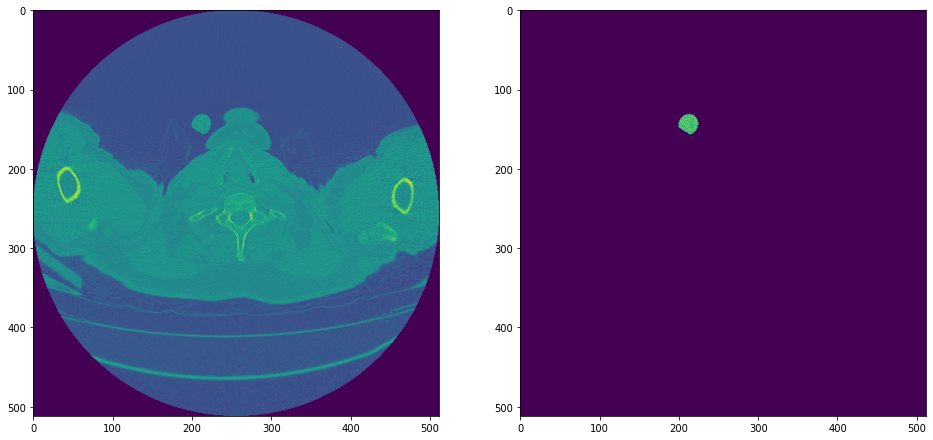

In [20]:
add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200)

In [21]:
volume_dict = get_series_name_and_len("D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Telesh_data\\Telesh\\")

In [23]:
volume_dict

{'3D Saved State - Processed Images': 9,
 'NATIV': 272,
 'ARTERIAL': 534,
 '1.25 STD': 265,
 'Processed Images': 2,
 'VENOZ': 534}

In [13]:

ct_scan = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Telesh_data\\Telesh\\"
volume_name = 'VENOZ'
annotations = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Telesh_data\\gt\\Telesh_body_Segment_1.nii"
class_index = 2
save_dir = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Telesh_data\\synt_data"

<class 'list'>
534


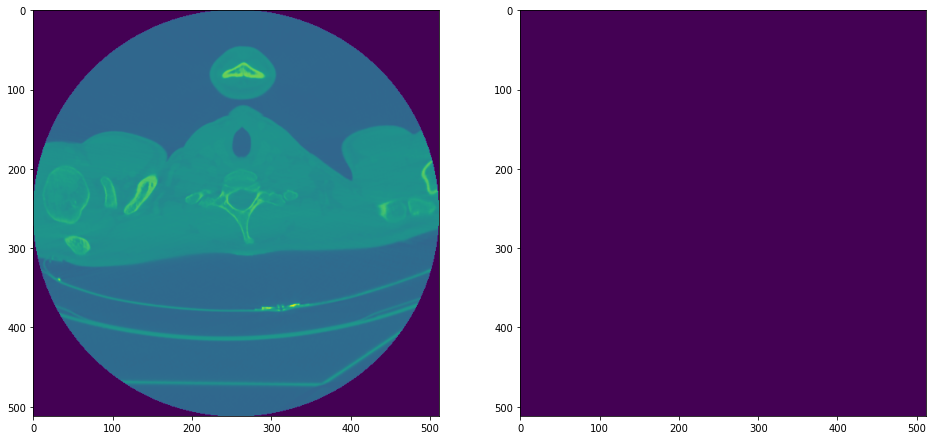

In [14]:
add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200)

In [10]:
volume_dict = get_series_name_and_len("D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\CT_06_09_20_Alekseev\\CT_06_09_20_Alekseev_data")
volume_dict

{'MEDIASTINUM, iDose (3)': 774, 'Art, iDose (3)': 774}

In [15]:
ct_scan = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\CT_06_09_20_Alekseev\\CT_06_09_20_Alekseev_data"
volume_name = 'Art, iDose (3)'
annotations = "D:\\neural_networks\легкие 3d\\lungs_db\\data_2\\CT_06_09_20_Alekseev\\gt\\Alekseev_body_Segment_1.nii"
class_index = 2
save_dir = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\CT_06_09_20_Alekseev\\synt_data"

<class 'list'>
774


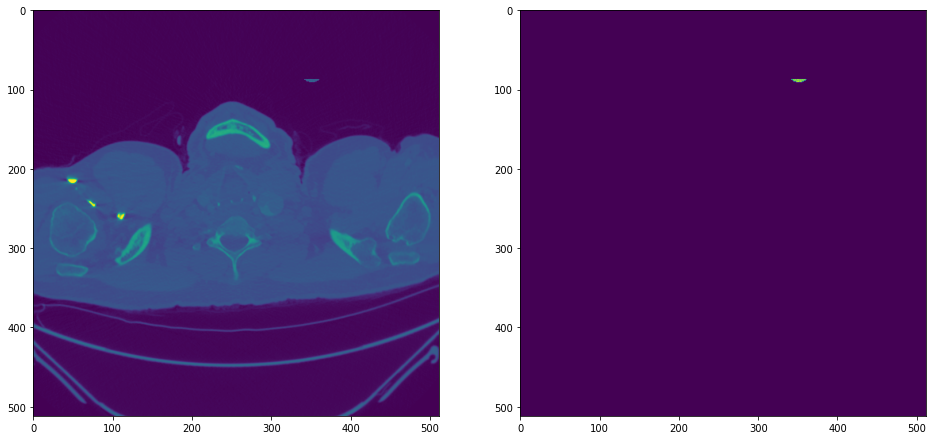

In [16]:
add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200)

In [21]:
volume_dict = get_series_name_and_len("D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Chingineva\\Chigineva_data")
volume_dict

{' Body 1.0   Vol.': 376, ' Lung 0.5   Vol.': 751}

In [27]:
ct_scan = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Chingineva\\Chigineva_data\\"
volume_name = ' Lung 0.5   Vol.'
annotations = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Chingineva\\gt\\Chigineva_body_Segment_1_1.nii"
class_index = 2
save_dir = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\Chingineva\\synt_data\\"

number of salices: 751
number of slices in annot: 751


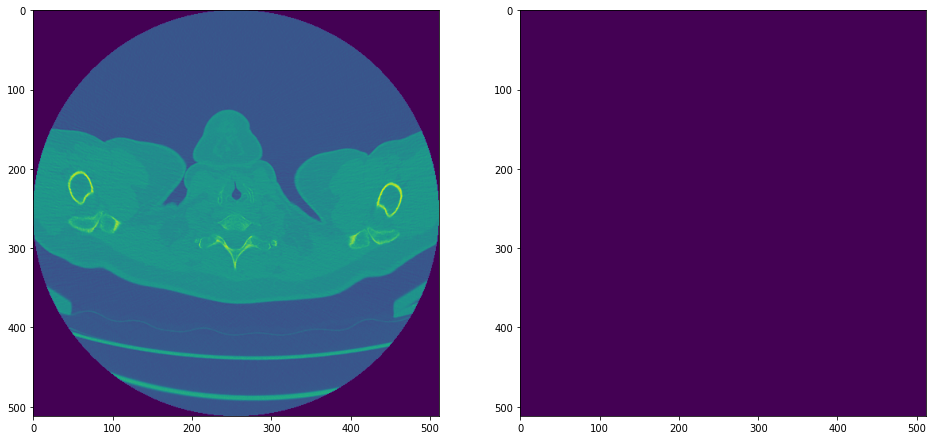

In [28]:
add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1100)

In [30]:
volume_dict = get_series_name_and_len("D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\3_CT\\3_CT_data")
volume_dict

{' CTA 1.0 CE CTA Vol.': 406}

In [32]:
ct_scan = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\3_CT\\3_CT_data\\"
volume_name = ' CTA 1.0 CE CTA Vol.'
annotations = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\3_CT\\gt\\PAT_1_3_body_1_Segment_1.nii"
class_index = 2
save_dir = "D:\\neural_networks\\легкие 3d\\Lungs_db\\data_2\\3_CT\\synt_data\\"

number of slices: 406
number of slices in annot: 406


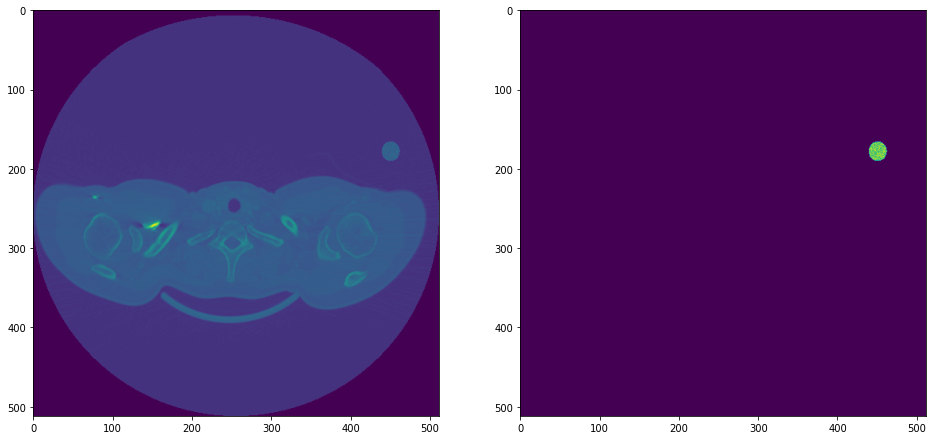

In [33]:
add_tube(ct_scan, volume_name, annotations, class_index, save_dir, tube_density = 1200)